## [Approximating a 1D Gaussian distribution](http://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
%matplotlib inline

In [2]:
class DataDistribution(object):
    def __init__(self):
        self.mu = 4
        self.sigma = 0.5

    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples

In [3]:
data = DataDistribution()

In [4]:
tz01 = data.sample(50)

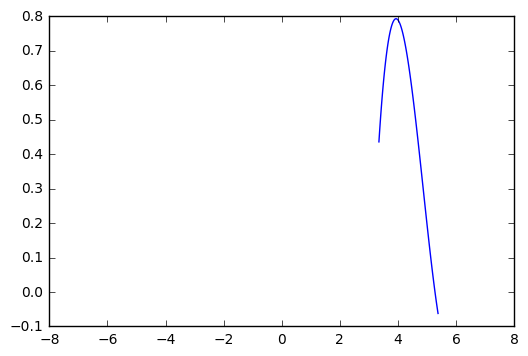

In [5]:
p, x = np.histogram(tz01, bins=100) # p = values of the histogram, x = edges
x = x[:-1]+(x[1]-x[0])/2

f = UnivariateSpline(x, p, s=100) 
# One-dimensional smoothing spline fit to a given set of data points
# s: Positive smoothing factor used to choose the number of knots. 

plt.plot(x, f(x))
plt.xlim([-8,8])
plt.show()

In [6]:
class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + \
            np.random.random(N) * 0.01

In [7]:
gen = GeneratorDistribution(8)
zt01 = gen.sample(50)

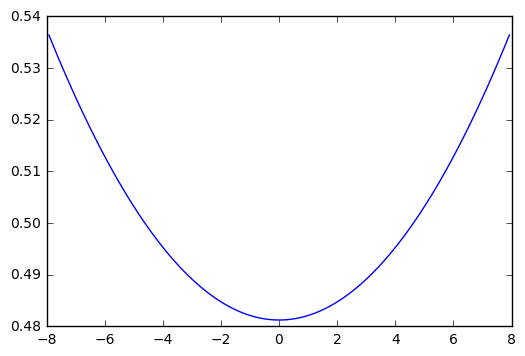

In [8]:
p, x = np.histogram(zt01, bins=100)
x = x[:-1]+(x[1]-x[0])/2
f = UnivariateSpline(x, p, s=100)
plt.plot(x, f(x))
plt.xlim([-8,8])
plt.show()

In [9]:
def linear(input, output_dim, scope=None, stddev=1.0):
    norm = tf.random_normal_initializer(stddev=stddev)
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], 
                            initializer=norm)
        b = tf.get_variable('b', [output_dim], initializer=const)
        return tf.matmul(input, w) + b

In [10]:
# Our generator and discriminator networks are quite simple. 
# The generator is a linear transformation passed through a nonlinearity (a softplus function), 
# followed by another linear transformation.

def generator(input, hidden_size):
    # Computes softplus: log(exp(features) + 1)
    h0 = tf.nn.softplus(linear(input, hidden_size, 'g0'))
    h1 = linear(h0, 1, 'g1')
    return h1

In [11]:
def discriminator(input, hidden_size):
    h0 = tf.tanh(linear(input, hidden_size * 2, 'd0'))
    h1 = tf.tanh(linear(h0, hidden_size * 2, 'd1'))
    h2 = tf.tanh(linear(h1, hidden_size * 2, 'd2'))
    h3 = tf.sigmoid(linear(h2, 1, 'd3'))
    return h3

In [12]:
# We can then connect these pieces together in a TensorFlow graph. We also define loss functions for each network, 
# with the goal of the generator being simply to fool the discriminator.

hidden_size = 10

with tf.variable_scope('G'):
    z = tf.placeholder(tf.float32, shape=(None, 1))
    G = generator(z, hidden_size)

with tf.variable_scope('D') as scope:
    x = tf.placeholder(tf.float32, shape=(None, 1))
    D1 = discriminator(x, hidden_size)
    scope.reuse_variables()
    D2 = discriminator(G, hidden_size)

loss_d = tf.reduce_mean(-tf.log(D1) - tf.log(1 - D2))
loss_g = tf.reduce_mean(-tf.log(D2))

In [13]:
def optimizer(loss, var_list):
    initial_learning_rate = 0.005
    decay = 0.95
    num_decay_steps = 150
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        batch,
        num_decay_steps,
        decay,
        staircase=True
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss,
        global_step=batch,
        var_list=var_list
    )
    return optimizer

vars = tf.trainable_variables()
d_params = [v for v in vars if v.name.startswith('D/')]
g_params = [v for v in vars if v.name.startswith('G/')]

opt_d = optimizer(loss_d, d_params)
opt_g = optimizer(loss_g, g_params)

## Build Graph and Run Graph

In [24]:
graph = tf.Graph()

with graph.as_default():
    class DataDistribution(object):
        def __init__(self):
            self.mu = 4
            self.sigma = 0.5

        def sample(self, N):
            samples = np.random.normal(self.mu, self.sigma, N)
            samples.sort()
            return samples
        
        
    class GeneratorDistribution(object):
        def __init__(self, range):
            self.range = range

        def sample(self, N):
            return np.linspace(-self.range, self.range, N) + \
                np.random.random(N) * 0.01
            
    def linear(input, output_dim, scope=None, stddev=1.0):
        norm = tf.random_normal_initializer(stddev=stddev)
        const = tf.constant_initializer(0.0)
        with tf.variable_scope(scope or 'linear'):
            w = tf.get_variable('w', [input.get_shape()[1], output_dim], 
                                initializer=norm)
            b = tf.get_variable('b', [output_dim], initializer=const)
            return tf.matmul(input, w) + b

    def generator(input, hidden_size):
        # Computes softplus: log(exp(features) + 1)
        h0 = tf.nn.softplus(linear(input, hidden_size, 'g0'))
        h1 = linear(h0, 1, 'g1')
        return h1

    def discriminator(input, hidden_size):
        h0 = tf.tanh(linear(input, hidden_size * 2, 'd0'))
        h1 = tf.tanh(linear(h0, hidden_size * 2, 'd1'))
        h2 = tf.tanh(linear(h1, hidden_size * 2, 'd2'))
        h3 = tf.sigmoid(linear(h2, 1, 'd3'))
        return h3

    with tf.variable_scope('G'):
        z = tf.placeholder(tf.float32, shape=(None, 1))
        G = generator(z, hidden_size)

    with tf.variable_scope('D') as scope:
        x = tf.placeholder(tf.float32, shape=(None, 1))
        D1 = discriminator(x, hidden_size)
        scope.reuse_variables()
        D2 = discriminator(G, hidden_size)

    loss_d = tf.reduce_mean(-tf.log(D1) - tf.log(1 - D2))
    loss_g = tf.reduce_mean(-tf.log(D2))

    def optimizer(loss, var_list):
        initial_learning_rate = 0.005
        decay = 0.95
        num_decay_steps = 150
        batch = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(
            initial_learning_rate,
            batch,
            num_decay_steps,
            decay,
            staircase=True
        )
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
            loss,
            global_step=batch,
            var_list=var_list
        )
        return optimizer

    vars = tf.trainable_variables()
    d_params = [v for v in vars if v.name.startswith('D/')]
    g_params = [v for v in vars if v.name.startswith('G/')]

    opt_d = optimizer(loss_d, d_params)
    opt_g = optimizer(loss_g, g_params)

In [40]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    
    num_steps = 500; batch_size = 50

    for step in range(num_steps):
        
        # update discriminator
        x1 = data.sample(batch_size)
        z1 = gen.sample(batch_size)
        
        l_d, o_d = session.run([loss_d, opt_d], {
            x: np.reshape(x1, (batch_size, 1)),
            z: np.reshape(z1, (batch_size, 1))
        })

        # update generator
        z1 = gen.sample(batch_size)
        l_g, o_g = session.run([loss_g, opt_g], {
            z: np.reshape(z1, (batch_size, 1))
        })
        
        print("{}. Discriminator: {}\t Generator: {}".format(step, l_d, l_g))

0. Discriminator: 5.041159152984619	 Generator: 0.8601775169372559
1. Discriminator: 1.6647764444351196	 Generator: 0.9553909301757812
2. Discriminator: 1.400146484375	 Generator: 1.0422019958496094
3. Discriminator: 1.2299529314041138	 Generator: 1.1268125772476196
4. Discriminator: 1.0856938362121582	 Generator: 1.2114473581314087
5. Discriminator: 0.9590374231338501	 Generator: 1.2985749244689941
6. Discriminator: 0.8400717973709106	 Generator: 1.3877431154251099
7. Discriminator: 0.7288222312927246	 Generator: 1.4785972833633423
8. Discriminator: 0.6282659769058228	 Generator: 1.5713025331497192
9. Discriminator: 0.541938304901123	 Generator: 1.6686419248580933
10. Discriminator: 0.4667285084724426	 Generator: 1.7747414112091064
11. Discriminator: 0.39727646112442017	 Generator: 1.8919456005096436
12. Discriminator: 0.3338836431503296	 Generator: 2.014335870742798
13. Discriminator: 0.2768231928348541	 Generator: 2.129129409790039
14. Discriminator: 0.23830313980579376	 Generator: 

In [39]:
print("{0:.2f}".format(2.55666))

2.56
